# Indoor Care Chatbot (YOLO + ChatGPT)

### Load the previously prepared OpenVINO optimized YOLOv8 model

In [1]:
from openvino.runtime import Core
core = Core()
# Load the pre optimized model
yolov8n_with_preprocess_model = core.read_model('models/yolov8n_openvino_int8_model/yolov8n_with_preprocess.xml',)

import json
# Load the label map
with open('models/yolov8n_labels.json', 'r') as f:
    label_map = json.load(f)
    label_map = {int(k): v for k, v in label_map.items()}

# Camera source could be different for different systems, please test with `run_object_detection` function
CAMERA_SOURCE = 0
# distance_confidence_matrix, all_detected_objects = run_object_detection(source=0, flip=True, model=yolov8n_with_preprocess_model, label_map=label_map, core=core, device="AUTO", interval=500)

### Setup YOLO Chat!

#### Following are the OpenAI Chat functions we are going to use:

We are going to try the use the new functions capablities of OpenAI to use the YOLO detection results to generate a response.

Following are the functions we are going to use:

- 'interpret_distance_from_object': Interpret the distance of the detected object from the user.

- 'locate_object': locate an object in the scene.

- 'is_pathway_clear': Check if the pathway is clear.

Following are few more potensially helpful functions one could use to improve this project:

- Fall Detection: Implement a function that analyzes the posture of the person in the video. If it identifies the person as being horizontal (which could be indicative of a fall), it sends an alert.

- Reminder System: Integrate the chatbot with a smart home system so that the elderly person could ask the chatbot to remind them where they put certain items. When the item is located, the chatbot would remember its location and can recall it when asked.

- Emergency Situation Handler: In an emergency situation where the person can't move, they can tell the chatbot to call for help. The chatbot could be programmed to either call a predetermined contact or emergency services.

- Face Recognition: Implement face recognition capabilities to help those suffering from dementia. The system could recognize faces and remind the person of who they are.

- Medicine Reminder: Configure the chatbot to recognize the elderly person's face and remind them to take their medication.

- Visitor Verification: If connected to a security camera at the door, the chatbot can inform the person who is at the door. It could even be connected to the lock and unlock the door based on the person's instruction.

In [2]:
def log_to_file(message, filename='py.log'):
    """
    Log a message to an external log file
    Parameters:
        message (str): message to be logged
        filename (str): name of the log file. Default is 'py.log'.
    """
    with open(filename, 'w') as log_file:
        log_file.write(f'{message}\n')


In [3]:
def interpret_distance_from_object(object_name, distance_confidence_matrix, all_detected_objects):
    messages = []
    distance_confidence_matrix, all_detected_objects = view_camera_remover(distance_confidence_matrix, all_detected_objects)
    if "person" in all_detected_objects and object_name in all_detected_objects:
        counter = 0
        for data in distance_confidence_matrix:
            if len(data) == 4:
                if (data[0] == object_name and data[1] == 'person') or (data[0] == object_name and data[1] == 'person'):
                    counter += 1
                    distance = data[2]
                    confidence = data[3]
                    distance_adjective = "quite close" if distance < 1 else "quite far"
                    confidence_adjective = "high" if confidence > 0.5 else "low"
                    messages.append(f"{counter} - Distance from {object_name} to person is {distance:.2f} meters with a {confidence_adjective} confidence. The {object_name} is {distance_adjective} to the person.\n")
    elif object_name in all_detected_objects and "person" not in all_detected_objects:
        messages.append(f"{object_name} found but no user detected nearby, therefore no distance from the {object_name} can be calculated")
    elif 'person' in all_detected_objects and object_name not in all_detected_objects:
        messages.append(f"user detected but no {object_name} found nearby, therefore no distance from the {object_name} can be calculated")

    return " ".join(messages)

def locate_object(object_name, distance_confidence_matrix, all_detected_objects):
    distance_confidence_matrix.reverse()
    if object_name in all_detected_objects:
        # Find the distance and confidence from the object to the camera
        for data in distance_confidence_matrix:
            if len(data) == 4 and ((data[0] == object_name and data[1] == 'view_camera') or (data[0] == 'view_camera') and data[1] == object_name):
                distance = data[2]
                confidence = data[3]
                distance_adjective = "quite close" if distance < 1 else "quite far"
                confidence_adjective = "high" if confidence > 0.5 else "low"
                return f"The {object_name} is detected in the scene. It is {distance_adjective} to the assistant with a {confidence_adjective} confidence."
        return f"The {object_name} is detected in the scene, but the distance to the assistant could not be calculated."
    else:
        return f"Sorry, the {object_name} is not detected in the scene."

def is_pathway_clear(object_name, distance_confidence_matrix, all_detected_objects):
    if 'view_camera' in all_detected_objects:
        # remove the view camera from the list of detected objects
        all_detected_objects.remove('view_camera')

    if len(all_detected_objects) != 0:
            return "I have checked through a YOLO Cam and determined that the pathway is not clear. And the user should move safely. Following are the objects detected in the scene: " + ", ".join(all_detected_objects)
    return "I have checked through a YOLO Cam and determined that the pathway is clear. And the user can move safely."

#### Setup the Chat config with the YOLO model, functions and jupyter widgets

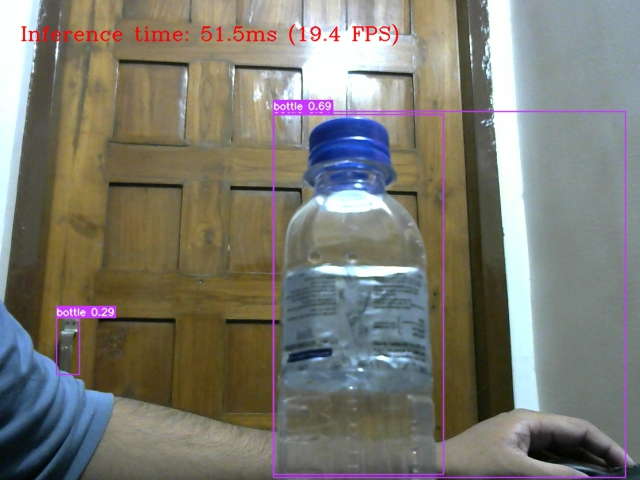

In [ ]:
import os
import openai
import json
from dotenv import load_dotenv
from datetime import datetime
from IPython.display import HTML, display
from ipywidgets import widgets, Output

from utils.objectDetect import run_object_detection

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

label_map_values = list(label_map.values())

model = "gpt-3.5-turbo-0613"

functions = [
        {
            "name": "interpret_distance_from_object",
            "description": "Find distance to any specified object from a user",
            "parameters": {
                "type": "object",
                "properties": {
                    "object_name": {
                        "type": "string",
                        "description": "The object to find the distance to",
                        "enum": label_map_values
                    },
                },
                "required": ["object_name"],
            }
        },
        {
            "name": "locate_object",
            "description": "Locate a specific object in the scene",
            "parameters": {
                "type": "object",
                "properties": {
                    "object_name": {
                        "type": "string",
                        "description": "The name of the object to locate",
                        "enum": label_map_values
                    },
                },
                "required": ["object_name"],
            }
        },
        {
            "name": "is_pathway_clear",
            "description": "Checks if the pathway is clear",
            "parameters": {
                "type": "object",
                "properties": {},
            }
        }
    ]

# Define available functions names
available_functions = {
    "interpret_distance_from_object": interpret_distance_from_object,
    "locate_object": locate_object,
    "is_pathway_clear": is_pathway_clear
}

# Define widget for UI
in_text = widgets.Text()
in_text.placeholder = "Type your message here, press enter to send."
in_text.add_class("form-control bg-light text-dark border border-primary rounded bg-light")
in_text.continuous_update = False
output = widgets.Output()

# Chat history
chat_history = [
    {
        "role": "system", 
        "content": """ You are an elderly care assistant.
You have to help and guide the elderly in their daily life whenever they need it.
You are are bot connected to a YOLO Camera.
So you will have capablities to call functions to interact with the environment.
You are obviously placed in a room."""
    }
]

def chat_wrapper(messages, functions=[]):
    if functions != []:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            functions=functions,
            function_call="auto",  # auto is default, but we'll be explicit
        )
        return response["choices"][0]["message"]
    else:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
        )
        return response["choices"][0]["message"]

def text_eventhandler(*args):
    # Needed bc when we "reset" the text input
    # it fires instantly another event since
    # we "changed" it's value to ""
    if args[0]["new"] == "":
        return

    # Show loading animation
    loading_bar.layout.display = "block"

    # Get question
    question = args[0]["new"]

    # Reset text field
    args[0]["owner"].value = ""

    # Formatting question for output
    q = (
        f'<div class="chat-message-right pb-4"><div>'
        + f'<img src="images/bear.png" class="rounded-circle mr-1" width="40" height="40">'
        + f'<div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div>'
        + '<div class="flex-shrink-1 bg-light rounded py-2 px-3 ml-3">'
        + f'<div class="font-weight-bold mb-1">You</div>{question}</div>'
    )

    # Display formatted question
    output.append_display_data(HTML(q))

    # try:
    #     function_chat_history = chat_history.copy()
    #     function_chat_history.append({"role": "user", "content": question})
    #     response_message = chat_wrapper(function_chat_history, functions=functions)
    #     if response_message.get("function_call"):
    #         function_name = response_message["function_call"]["name"]
    #         function_to_call = available_functions[function_name]
    #         function_args = json.loads(response_message["function_call"]["arguments"])
    #         distance_confidence_matrix, all_detected_objects = run_object_detection(source=2, flip=True, model=yolov8n_with_preprocess_model, label_map=label_map, core=core, device="AUTO", interval=500)
    #         function_response = function_to_call(
    #             object_name=function_args.get("object_name"),
    #             distance_confidence_matrix=distance_confidence_matrix,
    #             all_detected_objects=all_detected_objects
    #         )
    #         chat_history.append(response_message)
    #         chat_history.append({"role": "function", "name": function_name, "content": function_response})
    #     answer = chat_wrapper(chat_history)["content"]
    # except Exception as e:
    #     answer = "<b>Error:</b> " + str(e)

    function_chat_history = chat_history.copy()
    function_chat_history.append({"role": "user", "content": question})
    response_message = chat_wrapper(function_chat_history, functions=functions)
    if response_message.get("function_call"):
        function_name = response_message["function_call"]["name"]
        function_to_call = available_functions[function_name]
        function_args = json.loads(response_message["function_call"]["arguments"])
        distance_confidence_matrix, all_detected_objects = run_object_detection(source=CAMERA_SOURCE, flip=True, model=yolov8n_with_preprocess_model, label_map=label_map, core=core, device="AUTO", interval=500)
        function_response = function_to_call(
            object_name=function_args.get("object_name"),
            distance_confidence_matrix=distance_confidence_matrix,
            all_detected_objects=all_detected_objects
        )
        chat_history.append(response_message)
        chat_history.append({"role": "function", "name": function_name, "content": function_response})
    answer = chat_wrapper(chat_history)["content"]

    # Formatting answer for output
    # Replacing all $ otherwise matjax would format them in a strange way
    answer_formatted = answer.replace("$", r"\$")
    chat_history.append({"role": "assistant", "content": answer_formatted})
    a = (
        f'<div class="chat-message-left pb-4"><div>'
        + f'<img src="images/cat.png" class="rounded-circle mr-1" width="40" height="40">'
        + f'<div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div>'
        + '<div class="flex-shrink-1 bg-light rounded py-2 px-3 ml-3">'
        + f'<div class="font-weight-bold mb-1">Elder care Chatbot (YOLO Chat)</div>{answer_formatted}</div>'
    )

    # Turn off loading animation
    loading_bar.layout.display = "none"
    output.append_display_data(HTML(a))

in_text.observe(text_eventhandler, "value")

file = open("images/loading.gif", "rb")
image = file.read()
loading_bar = widgets.Image(
    value=image, format="gif", width="20", height="20", layout={"display": "None"}
)


### Run the chatbot

In [5]:
clear_button = widgets.Button(description="Clear the chat history")
clear_button.layout.margin = "0px 0px 0px auto"

hbox_widgets = widgets.HBox(
                    [output],
                    layout=widgets.Layout(
                        width="100%",
                        max_height="500px",
                        display="inline-flex",
                        flex_flow="column-reverse",
                    ),
                )

box_widget = widgets.Box(
                children=[loading_bar, in_text, clear_button],
                layout=widgets.Layout(display="flex", flex_flow="row"),
            )

# clear display and chat history
def reset_display(*args):
    output.clear_output()
    chat_history[:] = chat_history[:1]
    display(hbox_widgets)
    display(box_widget)

clear_button.on_click(reset_display)
# Init display
reset_display()

Box(children=(Image(value=b'GIF89a\xc8\x00\xc8\x00\xf7\x00\x00;Ch\x83\x90\xb7\xcf\xdc\xe8\xda\xec\xf1\xf1\xf2\…

Box(children=(Image(value=b'GIF89a\xc8\x00\xc8\x00\xf7\x00\x00;Ch\x83\x90\xb7\xcf\xdc\xe8\xda\xec\xf1\xf1\xf2\…

Box(children=(Image(value=b'GIF89a\xc8\x00\xc8\x00\xf7\x00\x00;Ch\x83\x90\xb7\xcf\xdc\xe8\xda\xec\xf1\xf1\xf2\…

Execute the below HTML cell to fix the styling of the chatbot

In [6]:
%%html
<link rel="stylesheet" 
      href="https://cdn.jsdelivr.net/npm/bootstrap@4.5.3/dist/css/bootstrap.min.css" 
      integrity="sha384-TX8t27EcRE3e/ihU7zmQxVncDAy5uIKz4rEkgIXeMed4M0jlfIDPvg6uqKI2xXr2" 
      crossorigin="anonymous">
<style>
    body{
        margin-top:20px;
        background-color: #2b2b2b; /* Dark background color */
        color: #2b2b2b; /* Light font color */
    }

    .chat-message-left,
    .chat-message-right {
        display: flex;
        flex-shrink: 0
    }

    .chat-message-left {
        margin-right: auto
    }

    .chat-message-right {
        flex-direction: row-reverse;
        margin-left: auto
    }
</style>